In [1]:
%cd ../
%load_ext autoreload

%autoreload 2

/home/giacomo/projects/emplusvault


In [14]:
import os
import random
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import cv2
from numba import jit
from ast import literal_eval

from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import pairwise_distances
from sklearn.manifold import trustworthiness
from sklearn.decomposition import PCA
from hdbscan import HDBSCAN
from umap import UMAP
from umap.umap_ import nearest_neighbors

from emv.features.pose import load_poses 
from emv.features.pose_utils import draw_pose, CONNECTIONS, KEYPOINTS_NAMES, ANGLES_ASSOCIATIONS
from emv.features.pose_utils import compute_hips_angles, normalize_angles

In [3]:
local_poses_path = "data/sample_pose_df.csv"
pose_df = load_poses(local_poses_path, filter_poses={})

pose_df = pose_df[pose_df.keypoints.map(lambda x: x[7][2] > 0.5 and x[8][2] > 0.5)]

Loading poses from local file...
Loaded 262145 poses.


# Computing features

In [4]:
pose_df["hips_angles"] = pose_df.keypoints.map(lambda x: compute_hips_angles(x)[0])
pose_df["hips_angles"] = pose_df["hips_angles"].map(lambda x: normalize_angles(x))

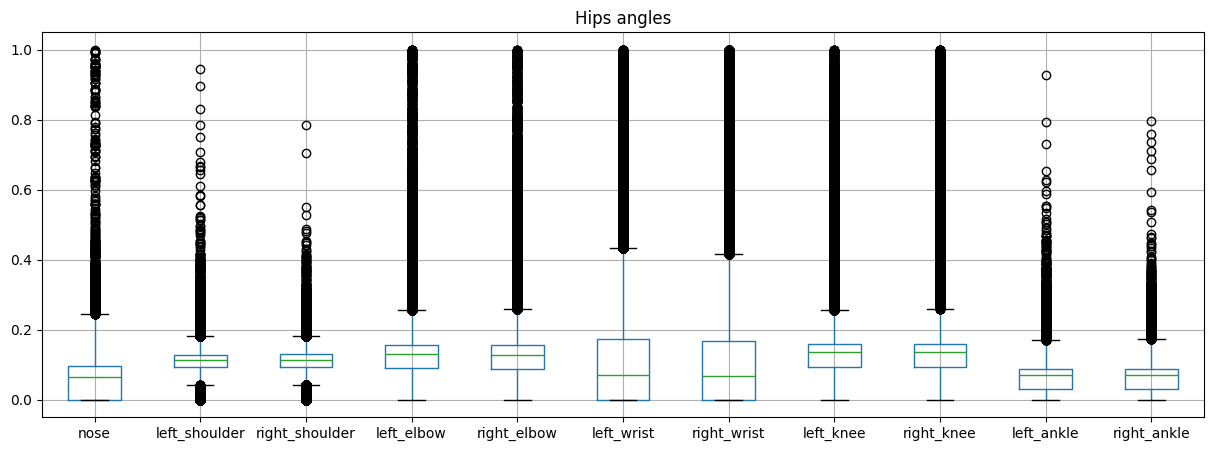

In [5]:
keypoints_names = [k for k in KEYPOINTS_NAMES if k != "left_hip" and k != "right_hip"]

hips_angles = pd.DataFrame(pose_df["hips_angles"].to_list(), columns = keypoints_names)
hips_angles_means = hips_angles.mean()
hips_angles_std = hips_angles.std()

plt.figure(figsize=(15, 5))
hips_angles.boxplot()
plt.title("Hips angles")
plt.show()

In [9]:
angles = pd.DataFrame(pose_df.angle_vec.tolist(), columns = ANGLES_ASSOCIATIONS.keys())

default_angles = []
for angle in ANGLES_ASSOCIATIONS.keys():
    non_missing_angles = angles[angles[angle] != 0][angle]
    default_angles.append(non_missing_angles.mean())

random_size = 0.0001
pose_df["angle_vec"] = pose_df.angle_vec.map(lambda x: [a if a != 0 else default_angles[i] + random.random() * random_size for i,a in enumerate(x)])

# Embedding

In [11]:
sport = "Weightlifting"
sport_poses = pose_df[pose_df.sport == sport]
print(f"Testing with {len(sport_poses)} poses from {sport}.")

Testing with 9963 poses from Weightlifting.


In [12]:
def compute_umap_embeddings(features, n_neighbors, min_dist = 0.01, metric = "cosine"):

    knn = nearest_neighbors(features, 
                            n_neighbors=np.max(n_neighbors), 
                            metric=metric,
                            metric_kwds={},
                            angular=False,
                            random_state=None)
    umap_embeddings = []
    for n in n_neighbors:
        reducer = umap.UMAP(n_neighbors=n, min_dist=min_dist, metric=metric, precomputed_knn=knn)
        embeddings = reducer.fit_transform(features)
        pairwise_d = pairwise_distances(embeddings, metric="euclidean")
        umap_embeddings.append({"n_neighbors": n, "embedding": embeddings, "pairwise_d": pairwise_d})
        
    return umap_embeddings
        
def plot_umap_embeddings(embeddings, d = 4, min_dist = 0.01):
    fig, axs = plt.subplots(nrows=1, ncols=len(n_neighbors), figsize=(len(n_neighbors) * d, d))
    for i, result in enumerate(embeddings):
        coords = result["embedding"]
        axs[i].scatter(coords[:,0], coords[:,1], s=0.1)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(f"n_neighbors = {result['n_neighbors']}")
        if i == 0:
            axs[i].set_ylabel(f"min_dist = {min_dist}")
    plt.tight_layout()
    plt.show()

In [13]:
n_neighbors = [50, 100, 500, 1000]

human_angles_embeddings = compute_umap_embeddings(features = np.array(sport_poses["angle_vec_fix"].tolist()), 
                                                  n_neighbors = n_neighbors)
hips_angles_embeddings = compute_umap_embeddings(features = np.array(sport_poses["hips_angles"].tolist()), 
                                                 n_neighbors = n_neighbors)

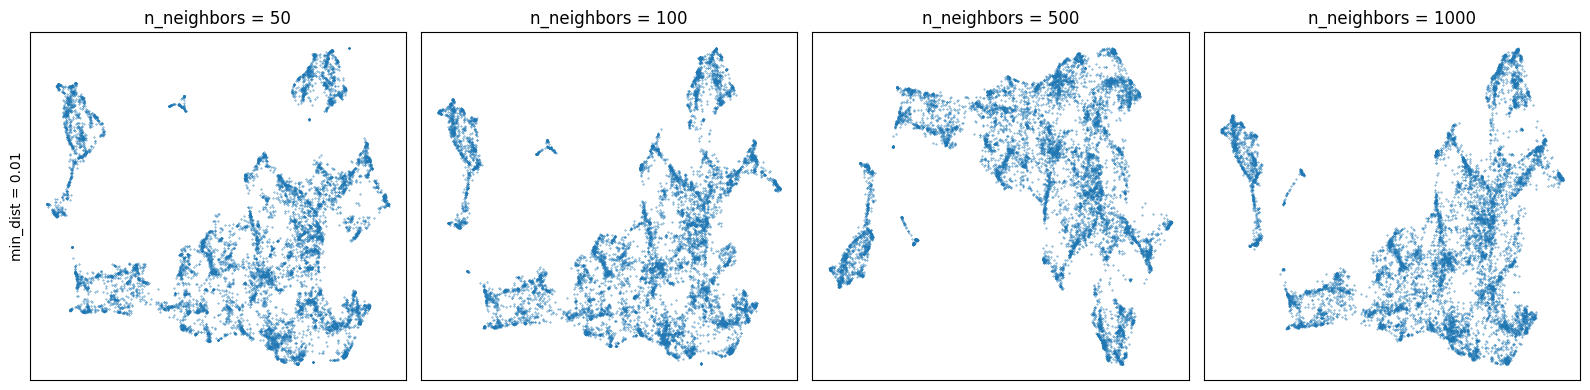

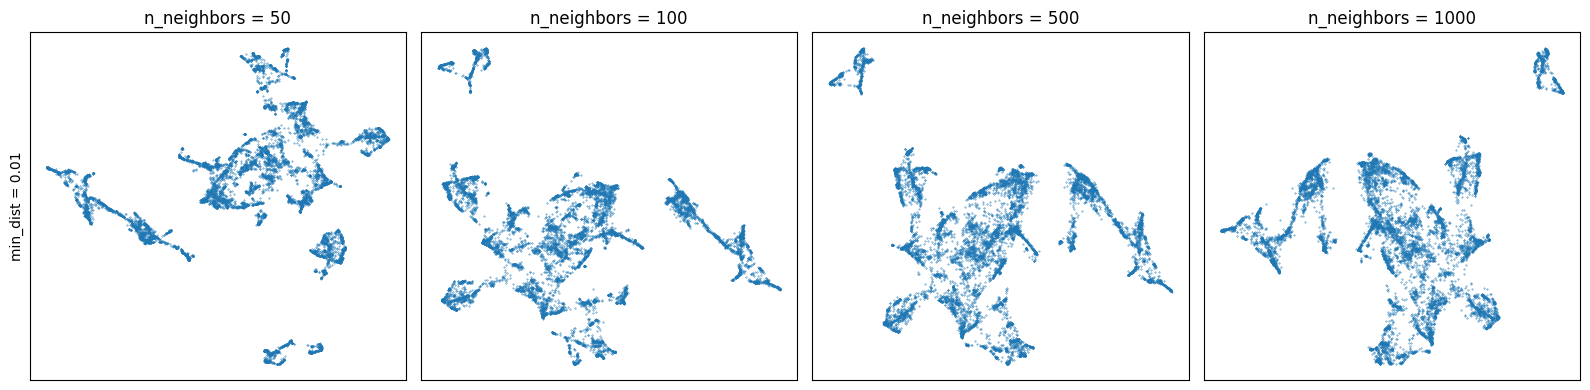

In [15]:
plot_umap_embeddings(human_angles_embeddings)
plot_umap_embeddings(hips_angles_embeddings)

In [16]:
def evaluate_embeddings(original_features, embeddings, ks = [10, 50, 100, 500, 1000]):
    original_d = pairwise_distances(original_features, metric="euclidean")
    
    results = []
    for embedding in embeddings:
        t_values = []
        for k in ks:
            t_values.append(trustworthiness(original_d, embedding["embedding"], n_neighbors=k, metric="precomputed"))
        results.append({"n_neighbors": embedding["n_neighbors"], "t_values": t_values})
        
    plt.figure(figsize=(10,5))  
    for result in results:
        plt.plot(ks, result["t_values"], label=f"n_neighbors = {result['n_neighbors']}")
    plt.legend()
    plt.show()

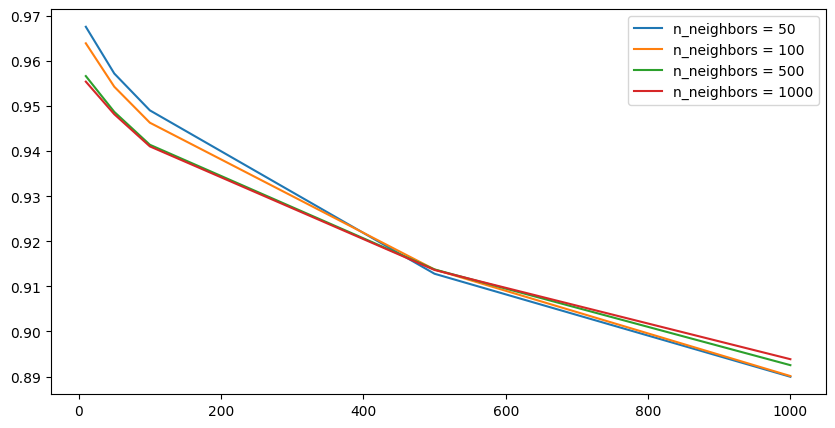

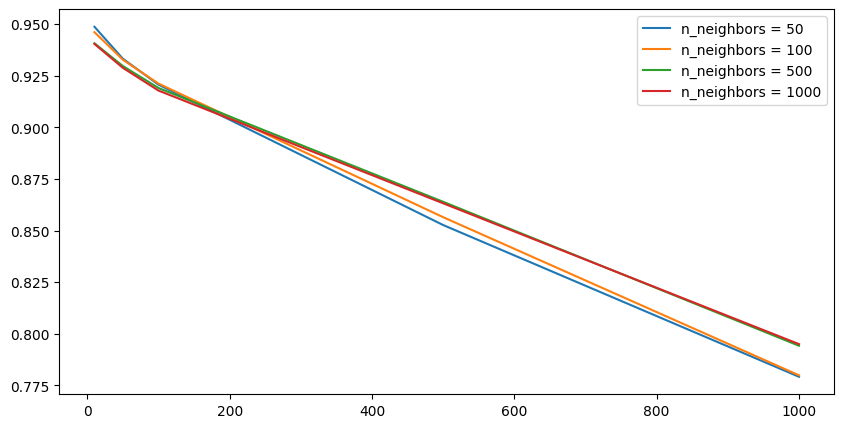

In [17]:
evaluate_embeddings(sport_poses["angle_vec_fix"].tolist(), human_angles_embeddings)
evaluate_embeddings(sport_poses["hips_angles"].tolist(), hips_angles_embeddings)

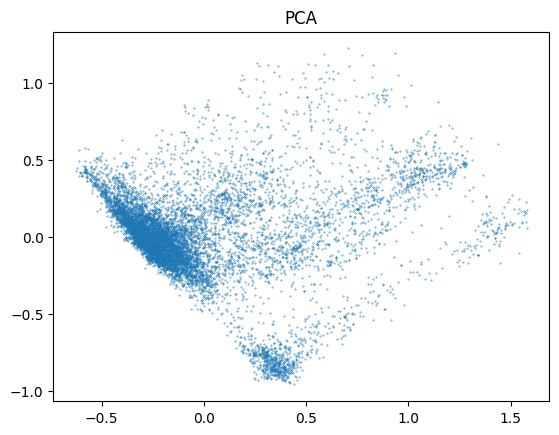

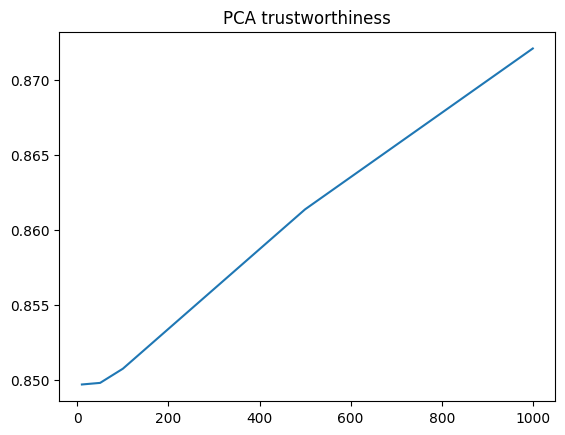

In [19]:
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(sport_poses["angle_vec_fix"].tolist())

plt.scatter(pca_embeddings[:,0], pca_embeddings[:,1], s=0.1)
plt.title("PCA")
plt.show()

ks = [10, 50, 100, 500, 1000]
t_values = []
original_d = pairwise_distances(sport_poses["angle_vec_fix"].tolist(), metric="euclidean")
for k in ks:
    t_values.append(trustworthiness(original_d, pca_embeddings, n_neighbors=k, metric="precomputed"))
    
plt.plot(ks, t_values)
plt.title("PCA trustworthiness")
plt.show()